# Proyek Klasifikasi Gambar: Scene Classification
- **Nama:** Zhulfani Faisal Adam
- **Email:** zhfa34@gmail.com
- **ID Dicoding:** zhulfani

## Import Semua Packages/Library yang Digunakan

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# import tensorflowjs as tfjs

## Data Preparation

### Data Loading

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/scene-classification/test_WyRytb0.csv
/kaggle/input/scene-classification/train-scene classification/train.csv
/kaggle/input/scene-classification/train-scene classification/train/19812.jpg
/kaggle/input/scene-classification/train-scene classification/train/22735.jpg
/kaggle/input/scene-classification/train-scene classification/train/16916.jpg
/kaggle/input/scene-classification/train-scene classification/train/7981.jpg
/kaggle/input/scene-classification/train-scene classification/train/22706.jpg
/kaggle/input/scene-classification/train-scene classification/train/20513.jpg
/kaggle/input/scene-classification/train-scene classification/train/12666.jpg
/kaggle/input/scene-classification/train-scene classification/train/13288.jpg
/kaggle/input/scene-classification/train-scene classification/train/20088.jpg
/kaggle/input/scene-classification/train-scene classification/train/6234.jpg
/kaggle/input/scene-classification/train-scene classification/train/1269.jpg
/kaggle/input/scene-c

In [3]:
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/kaggle/input/scene-classification/train-scene classification/train.csv")
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [4]:
IMG_SIZE = 299  # InceptionV3 input size
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 6  # 6 scene categories


In [5]:
df.shape

(17034, 2)

In [6]:
print(df['label'].unique())

[0 4 5 1 2 3]


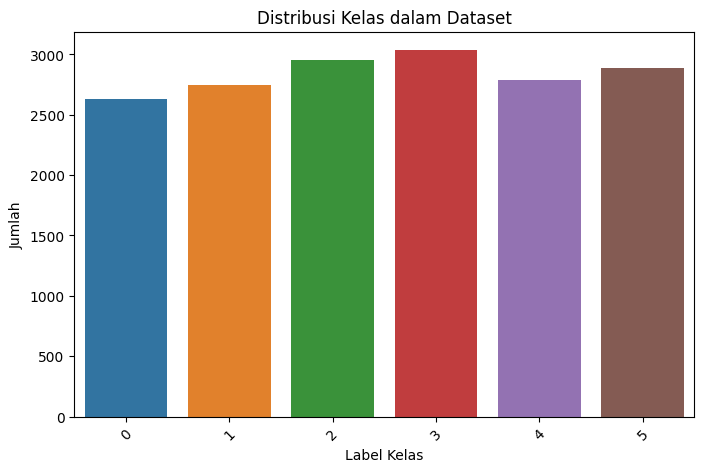

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df['label'])
plt.title('Distribusi Kelas dalam Dataset')
plt.xlabel('Label Kelas')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.show()

In [8]:
# test_file_path = "/kaggle/input/scene-classification/test_WyRytb0.csv"

# test = pd.read_csv(test_file_path)

In [9]:
# test.shape

### Data Preprocessing

In [10]:
df['label'] = df['label'].astype(str)

#### Split Dataset

In [11]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)  # 80% Train
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 10% Val, 10% Test

# Cek jumlah data setelah dibagi
print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

Train: 13627, Validation: 1703, Test: 1704


In [12]:
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,    # Rotasi gambar (cocok untuk pemandangan)
    width_shift_range=0.2,  # Geser gambar secara horizontal
    height_shift_range=0.2, # Geser gambar secara vertikal
    zoom_range=0.2,        # Zoom in/out
    horizontal_flip=True,  # Flip horizontal (masuk akal untuk pemandangan)
    brightness_range=[0.7, 1.3],  # Variasi kecerahan
    fill_mode='nearest'
)

In [13]:
dir = "/kaggle/input/scene-classification/train-scene classification/train"

In [14]:
# Only rescaling for validation and test
test_val_gen = ImageDataGenerator(rescale=1./255)

In [15]:
train_gen=data_gen.flow_from_dataframe(dataframe=train_df,
                                        directory=dir,
                                        x_col='image_name',
                                        y_col='label',
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical')

Found 13627 validated image filenames belonging to 6 classes.


In [16]:
val_gen=test_val_gen.flow_from_dataframe(dataframe=val_df,
                                        directory=dir,
                                        x_col='image_name',
                                        y_col='label',
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1703 validated image filenames belonging to 6 classes.


In [17]:
test_gen=test_val_gen.flow_from_dataframe(dataframe=test_df,
                                        directory=dir,
                                        x_col='image_name',
                                        y_col='label',
                                        target_size=(IMG_SIZE, IMG_SIZE),
                                        batch_size=BATCH_SIZE,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1704 validated image filenames belonging to 6 classes.


In [18]:
# Check class indices
print("\nClass indices mapping:")
print(train_gen.class_indices)


Class indices mapping:
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}


## Modelling

In [19]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [20]:
# Freeze the base model layers
for layer in base_model.layers[-30:]:  # Unfreeze 30 layer terakhir
    layer.trainable = True

In [21]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    # Add the InceptionV3 base model
    base_model,
    
    # Add Conv2D and Pooling layers as requested
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Add custom layers on top
    GlobalAveragePooling2D(),
    
    # Flatten the output for classification
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 8, 8, 256)           │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_94               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 4, 4, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_95               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,852,774 (102.44 MB)

 Trainable params: 26,817,574 (102.30 MB)

 Non-trainable params: 35,200 (137.50 KB)

In [24]:
# Callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Turunkan learning rate jika val_loss tidak membaik
    patience=3, 
    verbose=1
)

In [26]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [27]:
# Train the model
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

Epoch 1/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7437 - loss: 0.7011
Epoch 1: val_accuracy improved from -inf to 0.92249, saving model to best_model.keras
426/426 ━━━━━━━━━━━━━━━━━━━━ 601s 1s/step - accuracy: 0.7439 - loss: 0.7005 - val_accuracy: 0.9225 - val_loss: 0.2270 - learning_rate: 1.0000e-04
Epoch 2/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.8996 - loss: 0.2932
Epoch 2: val_accuracy did not improve from 0.92249
426/426 ━━━━━━━━━━━━━━━━━━━━ 385s 889ms/step - accuracy: 0.8996 - loss: 0.2932 - val_accuracy: 0.9201 - val_loss: 0.2644 - learning_rate: 1.0000e-04
Epoch 3/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.9134 - loss: 0.2551
Epoch 3: val_accuracy did not improve from 0.92249
426/426 ━━━━━━━━━━━━━━━━━━━━ 383s 884ms/step - accuracy: 0.9134 - loss: 0.2552 - val_accuracy: 0.9102 - val_loss: 0.2511 - learning_rate: 1.0000e-04
Epoch 4/20
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.9230 - loss: 0.2239
Epoch 4: val_accura

## Evaluasi dan Visualisasi

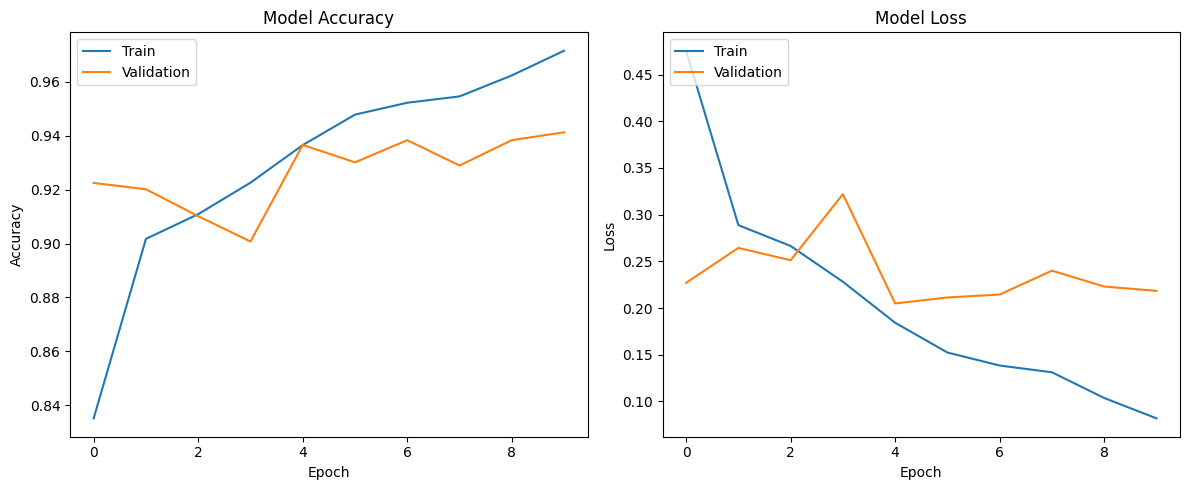

In [34]:
# Accuracy plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [38]:
# Prediction on test data
test_gen.reset()
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_gen.classes

# Get class labels for better visualization
labels = {v: k for k, v in train_gen.class_indices.items()}  # Ambil label dari training generator


class_labels = [labels[i] for i in range(NUM_CLASSES)]

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step


In [39]:
print("\nClassification Report:")
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       270
           1       0.99      0.98      0.99       256
           2       0.92      0.93      0.92       298
           3       0.93      0.93      0.93       312
           4       0.98      0.96      0.97       283
           5       0.95      0.95      0.95       285

    accuracy                           0.95      1704
   macro avg       0.95      0.95      0.95      1704
weighted avg       0.95      0.95      0.95      1704



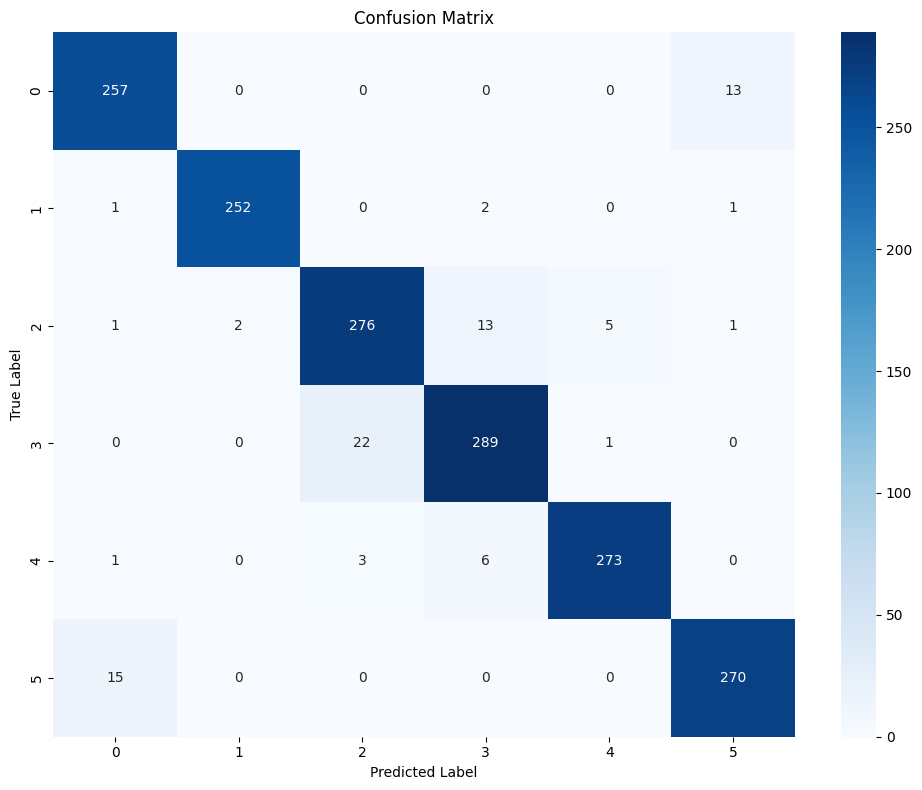

54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9498 - loss: 0.1410

Test Accuracy : 0.9489
Test Loss: 0.1374


In [44]:
plt.figure(figsize=(10,8))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(test_gen)
print(f"\nTest Accuracy : {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Analisis Confusion Matrix:
Diagonal dominan → Mayoritas prediksi benar karena angka di diagonal utama tinggi.

Kesalahan kecil → Beberapa label masih memiliki prediksi yang salah, misalnya:

Kelas 2 kadang diprediksi sebagai kelas 3.

Kelas 3 memiliki beberapa misclassifications ke kelas lain.

Kelas 5 ada sedikit kesalahan ke kelas 0.

Kelas tertentu lebih sulit dibedakan → Misalnya, kesalahan di sekitar kelas 2 dan 3 bisa menunjukkan kemiripan fitur antar kelas.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


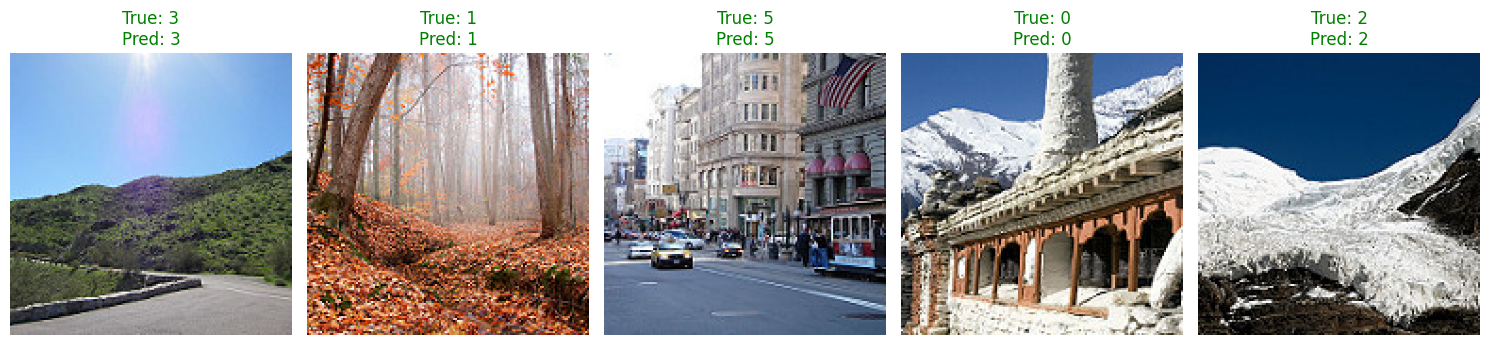

In [47]:
# Get a batch of images test
test_gen.reset()
batch_images, batch_labels = next(test_gen)

# Predictions

predictions = model.predict(batch_images)
predicted_classes = np.argmax(predictions, axis=1)

# Get class labels

labels = {v: k for k, v in train_gen.class_indices.items()}

# Display images with predictions

plt.figure(figsize=(15,10))
num_samples = 5

for i in range (min(num_samples, len(batch_images))):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(batch_images[i])
    true_label = labels[np.argmax(batch_labels[i])]
    pred_label = labels[predicted_classes[i]]
    title_color = 'green' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPred: {pred_label}', color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Konversi Model

In [49]:
model.save("best_model.h5")

In [52]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
plotnine 0.14.4 requires

In [53]:
import tensorflowjs as tfjs

# Tentukan path penyimpanan model dalam format TensorFlow.js
TFJS_PATH = "tfjs_model"

# Konversi model ke TensorFlow.js
tfjs.converters.save_keras_model(model, TFJS_PATH)

print(f"Model berhasil dikonversi ke TensorFlow.js dan disimpan di {TFJS_PATH}")


failed to lookup keras version from the file,
    this is likely a weight only file
Model berhasil dikonversi ke TensorFlow.js dan disimpan di tfjs_model


In [59]:
model.export("saved_model")
print("Model saved in TensorFlow SavedModel format.")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139314916351968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313045321536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314916350912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313044833376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314940759904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313043920976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313044835312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313045467056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313044840768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313043929248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313043925200

In [60]:
# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model dalam file .tflite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model saved in TFLite format.")

Saved artifact at '/tmp/tmp28cycc_v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139314916351968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313045321536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314916350912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313044833376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314940759904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313043920976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313044835312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313045467056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313044840768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139313043929248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1393130439

In [56]:
for i, layer in enumerate(model.layers):
    try:
        print(f"Layer {i}: {layer.name}, Output Shape: {layer.output.shape}")
    except AttributeError:
        print(f"Layer {i}: {layer.name}, Output Shape: (Tidak tersedia)")


Layer 0: inception_v3, Output Shape: (None, 8, 8, 2048)
Layer 1: conv2d_94, Output Shape: (None, 8, 8, 256)
Layer 2: batch_normalization_94, Output Shape: (None, 8, 8, 256)
Layer 3: max_pooling2d_4, Output Shape: (None, 4, 4, 256)
Layer 4: conv2d_95, Output Shape: (None, 4, 4, 128)
Layer 5: batch_normalization_95, Output Shape: (None, 4, 4, 128)
Layer 6: max_pooling2d_5, Output Shape: (None, 2, 2, 128)
Layer 7: global_average_pooling2d, Output Shape: (None, 128)
Layer 8: flatten, Output Shape: (None, 128)
Layer 9: dropout, Output Shape: (None, 128)
Layer 10: dense, Output Shape: (None, 256)
Layer 11: dropout_1, Output Shape: (None, 256)
Layer 12: dense_1, Output Shape: (None, 6)


In [61]:
!pip freeze > /kaggle/working/requirements.txt

In [62]:
!zip -r folder.zip /kaggle/working

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/requirements.txt (deflated 57%)
  adding: kaggle/working/best_model.h5 (deflated 8%)
  adding: kaggle/working/best_model.keras (deflated 9%)
  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/saved_model/variables/ (stored 0%)
  adding: kaggle/working/saved_model/variables/variables.index (deflated 78%)
  adding: kaggle/working/saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: kaggle/working/saved_model/assets/ (stored 0%)
  adding: kaggle/working/saved_model/saved_model.pb (deflated 91%)
  adding: kaggle/working/model.tflite (deflated 7%)
  adding: kaggle/working/.virtual_documents/ (stored 0%)
  adding: kaggle/working/tfjs_model/ (stored 0%)
  adding: kaggle/working/tfjs_model/group1-shard14of26.bin (deflated 7%)
  adding: kaggle/working/tfjs_model/group1-shard11of26.bin (deflated 7%)
  adding: kaggle/working/

In [63]:
from IPython.display import FileLink
FileLink(r'folder.zip')

/kaggle/working/folder.zip